# Epileptic Seizure Prediction Case Study
We will be using this case study to combine both KNN and PCA to analyze a problem. 
Also, we will evaluate the performance using the F1 metric.

> This is a my own variation (but will become probably just a copy) from these two:
> * https://medium.com/analytics-vidhya/implementing-pca-in-python-with-sklearn-4f757fb4429e
> * https://www.kaggle.com/code/harunshimanto/machine-learning-algorithms-for-epileptic-seizures

The original data should have been in https://archive-beta.ics.uci.edu/ml/datasets/epileptic+seizure+recognition but the folder was empty. We will be using a dataset coming from https://www.kaggle.com/code/harunshimanto/machine-learning-algorithms-for-epileptic-seizures/data


In [1]:
# Importing the needed libraries
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# tells matplotlib to embed plots within the notebook
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

## Load and visualiza the data

In [2]:
# Loading all data on a dictonary
data = pd.read_csv('Epileptic Seizure Recognition.csv')

In [3]:
data.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [4]:
data.keys()

Index(['Unnamed', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       ...
       'X170', 'X171', 'X172', 'X173', 'X174', 'X175', 'X176', 'X177', 'X178',
       'y'],
      dtype='object', length=180)

### Data description

The original dataset from the reference consists of 5 different folders, each with 100 files, with each file representing a single subject/person. Each file is a recording of brain activity for 23.6 seconds. The corresponding time-series is sampled into 4097 data points. Each data point is the value of the EEG recording at a different point in time. So we have total 500 individuals with each has 4097 data points for 23.5 seconds. 

We divided and shuffled every 4097 data points into 23 chunks, each chunk contains 178 data points for 1 second, and each data point is the value of the EEG recording at a different point in time. So now we have 23 x 500 = 11500 pieces of information(row), each information contains 178 data points for 1 second(column), the last column represents the label y {1,2,3,4,5}.

The response variable is y in column 179, the Explanatory variables X1, X2, ..., X178.
y contains the category of the 178-dimensional input vector. Specifically y in {1, 2, 3, 4, 5}:

* 5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open
* 4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed
* 3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area
* 2 - They recorder the EEG from the area where the tumor was located
* 1 - Recording of seizure activity 

All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have epileptic seizure. Our motivation for creating this version of the data was to simplify access to the data via the creation of a .csv version of it. Although there are 5 classes most authors have done binary classification, namely class 1 (Epileptic seizure) against the rest.

### Data preprocessing

We will be checking the following:
* Remove the first column "Unnamed" feature
* Check if there are any missing values
* Convert the dataframe into a numpy array 
* Convert $y$ into a binary variable. 1 represents a seizure event and 0 represents no-seizure
* Standardize the data

#### Remove the first column

In [5]:
data = data.drop('Unnamed', axis=1)

In [6]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


#### Look for any missing values
We are using <code>pandas</code> to look for <code>Null</code> or <code>NaN</code>. We'll see there are no <code>Null</code> values.

In [7]:
data.isnull().sum()

X1      0
X2      0
X3      0
X4      0
X5      0
       ..
X175    0
X176    0
X177    0
X178    0
y       0
Length: 179, dtype: int64

In [8]:
data.isnull().sum().sum()

0

#### Pass the data to a numpy array

In [9]:
X = data.iloc[:,:-1].to_numpy()
# I am not totally sure why I have to put the [] on [-1]. On this way I have a list of vectors also on y
y = data.iloc[:,[-1]].to_numpy()

#### Convert $y$ into a binary variable

In [10]:
# any training data different than 1 will be 0
y[y!=1]=0

<BarContainer object of 2 artists>

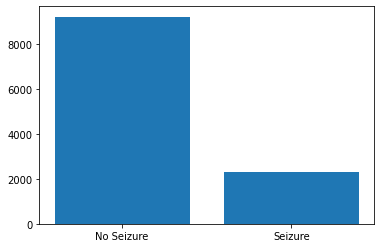

In [11]:
output = ['No Seizure', 'Seizure']
values = [np.count_nonzero(y==0), np.count_nonzero(y)]
plt.bar(output, values)

#### Standardize the data
returns a normalized version of X where the mean value of each feature is 0 and the standard deviation is 1.

In [12]:
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)

## Run PCA

We are analyzing how much variance in the dataset can be explained by the principal components.

In [41]:
# cum_var stores the accumulative variance values
pca = PCA(n_components=None)
X_pca = pca.fit_transform(X_std)
var_exp = pca.explained_variance_ratio_
cum_var= np.cumsum(var_exp)

<BarContainer object of 178 artists>

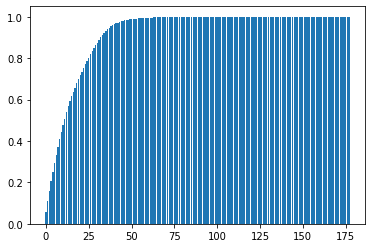

In [42]:
plt.bar(range(var_exp.size), cum_var)

In [43]:
# Let's find the first index above 0.99
# We will set this as the number of components in PCA
# because the features up to this index explain most 
# of the model
K= np.searchsorted(cum_var, 0.99)
print('From this index we explain more than 99% of the model: ', K)

From this index we explain more than 99% of the model:  52


In [44]:
pca = PCA(n_components=K)
X_pca = pca.fit_transform(X_std)

In [45]:
X_pca.shape

(11500, 52)

<div class="alert alert-block alert-success"> From now on we will continue our analysis with 52 features out of 178. Note that this reduces the amount of calculation to be done!</div>

## Divide training and test data

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca,
    y.ravel(),
    test_size=0.3,
    random_state=42,
    stratify=y)

# I use y.ravel() to flatten in 1D the y array 

In [47]:
X_train.shape

(8050, 52)

## Train a KNN model

In [48]:
# p=2 and 'minkowski' is equivalent to euclidean distance
knn = KNeighborsClassifier(n_neighbors=5,
                          p=2,
                          metric='minkowski')
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [49]:
knn.score(X_test, y_test)

0.9257971014492754

In [50]:
knn.score(X_train, y_train)

0.9372670807453416

## F1 Classification Metric

<b>F1 Score</b> is a more robust classification metric than <b>accuracy</b> when the classes are <b>imbalanced</b>.
Useful definitions:
* <b>precision</b>: fraction of <i>predicted</i> positives that were correctly predicted
* <b>recall</b>: fraction of <i>true</i> positives that were correctly predicted 

In [51]:
y_pred_test = knn.predict(X_test)
y_pred_train = knn.predict(X_train)

In [52]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
print(confmat)

[[2755    5]
 [ 251  439]]


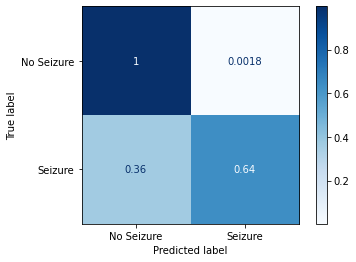

In [53]:
ConfusionMatrixDisplay.from_estimator(knn,
                                      X_test,
                                      y_test,
                                      display_labels=['No Seizure', 'Seizure'],
                                      normalize='true',
                                      cmap='Blues')

In [54]:
print(f'Train f1 Score: {f1_score(y_train, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

Train f1 Score: 0.8145427836944547
Test f1 Score: 0.7742504409171077
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2760
           1       0.99      0.64      0.77       690

    accuracy                           0.93      3450
   macro avg       0.95      0.82      0.86      3450
weighted avg       0.93      0.93      0.92      3450



<div class="alert alert-block alert-success"> We can see that the test F1 score is 0.77. In fact, the model seems to be very good predicting "No seizures", almos 100% of the 0 labels were predicted 0, but not as good predicting "Seizures", only 64% of the 1 labels were predicted 1.</div>

## Using F1 to find the optimal number of PCA components
We will now try to identify which is the optimal number of PCA components to run our model using F1 as a classification metric. 

In [78]:
train_f1 = list()
test_f1 = list()
n = 30

pca = PCA(n_components=178)
X_pca = pca.fit_transform(X_std)

In [84]:
for i in range(1,n):
    X_pca_i= X_pca[:, 0:i]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca_i,
        y.ravel(),
        test_size=0.3,
        random_state=42,
        stratify=y)
    
    knn = KNeighborsClassifier(n_neighbors=5,
                               p=2,
                               metric='minkowski')
    knn.fit(X_train, y_train) 
    
    y_pred_test = knn.predict(X_test)
    y_pred_train = knn.predict(X_train)
    
    train_f1.append(f1_score(y_train, y_pred_train))
    test_f1.append(f1_score(y_test, y_pred_test))

In [85]:
X_pca[:, 0:0]

array([], shape=(11500, 0), dtype=float64)

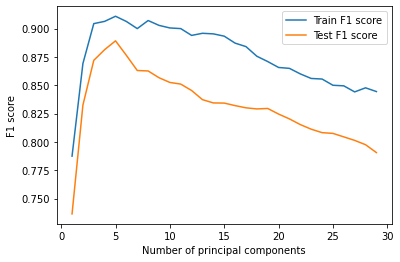

In [86]:
plt.plot(range(1,n), train_f1, label='Train F1 score')
plt.plot(range(1,n), test_f1, label='Test F1 score')
plt.ylabel('F1 score')
plt.xlabel('Number of principal components')
plt.legend()
plt.show()

We see in the diagram that both F1 scores are peaking when the number of principal components is 5.

#### Model estimation using the optimal number of principal components

In [102]:
X_pca_i= X_pca[:, :5]
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_i,
    y.ravel(),
    test_size=0.3,
    random_state=42,
    stratify=y)

knn = KNeighborsClassifier(n_neighbors=5,
                           p=2,
                           metric='minkowski')
knn.fit(X_train, y_train) 
    
y_pred_test = knn.predict(X_test)
y_pred_train = knn.predict(X_train)

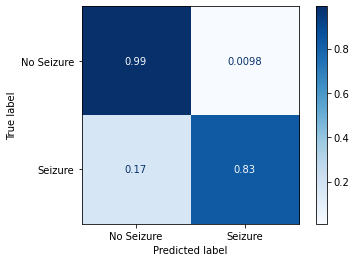

In [103]:
ConfusionMatrixDisplay.from_estimator(knn,
                                      X_test,
                                      y_test,
                                      display_labels=['No Seizure', 'Seizure'],
                                      normalize='true',
                                      cmap='Blues')

In [104]:
print(f'Train f1 Score: {f1_score(y_train, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

Train f1 Score: 0.9109364767518009
Test f1 Score: 0.8892331525948877
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2760
           1       0.96      0.83      0.89       690

    accuracy                           0.96      3450
   macro avg       0.96      0.91      0.93      3450
weighted avg       0.96      0.96      0.96      3450



<div class="alert alert-block alert-success"> To conclude we have seen that with only 5 principal components we can do far better than with a bigger number of features!</div>